# Introduction

The goal is to predict the monthly quantity of goods transported via airlines, basing on previous months.

data: https://www.kaggle.com/rajsengo/sfo-air-traffic-passenger-and-cargo-statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats

import os
import glob
import re

In [2]:
files = os.listdir('data')
csv_files = list(filter(lambda f: f.endswith('.csv'), files))
csv_files

['Air_Traffic_Cargo_Statistics.csv']

In [3]:
df = pd.read_csv(f'data/{csv_files[0]}')
df.head()

,activity_period,operating_airline,operating_airline_iata,published_airline,published_airline_iata,geo_summary,geo_region,activity_type,cargo_type,cargo_aircraft_type,cargo_weight_lbs,cargo_metric_tons
0,200507,ABX Air,GB,ABX Air,GB,Domestic,US,Deplaned,Cargo,Freighter,45423,20.603873
1,200507,ABX Air,GB,ABX Air,GB,Domestic,US,Enplaned,Cargo,Freighter,106869,48.475778
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Cargo,Passenger,55427,25.141687
3,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Mail,Passenger,50278,22.806101
4,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Cargo,Passenger,74183,33.649409


<AxesSubplot:>

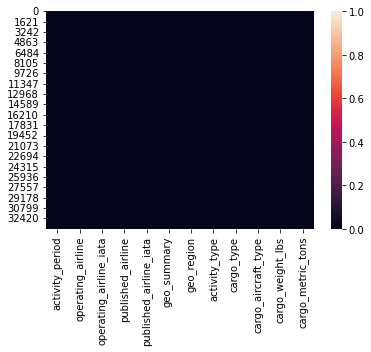

In [4]:
sns.heatmap(df.isna())

In [5]:
columns = list(df)
columns

['activity_period',
 'operating_airline',
 'operating_airline_iata',
 'published_airline',
 'published_airline_iata',
 'geo_summary',
 'geo_region',
 'activity_type',
 'cargo_type',
 'cargo_aircraft_type',
 'cargo_weight_lbs',
 'cargo_metric_tons']

In [6]:
for col in columns:
    print(df.value_counts(col))

activity_period
201908    210
201909    210
201907    209
201910    208
201906    207
         ... 
201406    155
202007    152
202006    129
202004    118
202005    117
Length: 186, dtype: int64
operating_airline
United Airlines                     3218
United Airlines - Pre 07/01/2013    2503
Korean Air Lines                    1457
Alaska Airlines                     1338
Asiana Airlines                     1239
                                    ... 
Qatar Airways                          4
Air Canada Jazz                        2
Focus Air                              2
E.A.G.L.E.                             1
Atlantic Southeast Airlines            1
Length: 96, dtype: int64
operating_airline_iata
UA    5721
KE    1457
AS    1338
OZ    1239
CI    1227
      ... 
XJ       5
YV       5
QR       4
QK       2
EV       1
Length: 88, dtype: int64
published_airline
United Airlines                      3226
United Airlines - Pre 07/01/2013     2511
Alaska Airlines                      18

## First approach - group the quantities by regions.

In [7]:
dates = df.index
dates

RangeIndex(start=0, stop=34037, step=1)

In [8]:
regions = df['geo_region'].drop_duplicates().values
regions

array(['US', 'Canada', 'Asia', 'Europe', 'Australia / Oceania', 'Mexico',
       'Central America', 'Middle East', 'South America'], dtype=object)

In [9]:
periods = df['activity_period'].drop_duplicates().values
periods

array([200507, 200508, 200509, 200510, 200511, 200512, 200601, 200602,
       200603, 200604, 200605, 200606, 200607, 200608, 200609, 200610,
       200611, 200612, 200701, 200702, 200703, 200704, 200705, 200706,
       200707, 200708, 200709, 200710, 200711, 200712, 200801, 200802,
       200803, 200804, 200805, 200806, 200807, 200808, 200809, 200810,
       200811, 200812, 200901, 200902, 200903, 200904, 200905, 200906,
       200907, 200908, 200909, 200910, 200911, 200912, 201001, 201002,
       201003, 201004, 201005, 201006, 201007, 201008, 201009, 201010,
       201011, 201012, 201101, 201102, 201103, 201104, 201105, 201106,
       201107, 201108, 201109, 201110, 201111, 201112, 201201, 201202,
       201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210,
       201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306,
       201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402,
       201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410,
      

In [10]:
columns_regions = ['activity_period','geo_region','cargo_metric_tons']

In [11]:
df_regions1 = df[columns_regions]
df_regions1

,activity_period,geo_region,cargo_metric_tons
0,200507,US,20.603873
1,200507,US,48.475778
2,200507,US,25.141687
3,200507,US,22.806101
4,200507,US,33.649409
...,...,...,...
34032,202012,Middle East,0.869098
34033,202012,Middle East,4.658926
34034,202012,Middle East,83.367144
34035,202012,Middle East,1.995840


In [12]:
df_regions2 = df_regions1.groupby(['activity_period', 'geo_region'], as_index = False)['cargo_metric_tons'].sum()
df_regions2

,activity_period,geo_region,cargo_metric_tons
0,200507,Asia,20071.889360
1,200507,Australia / Oceania,666.738929
2,200507,Canada,154.748362
3,200507,Central America,5.772967
4,200507,Europe,5559.357888
...,...,...,...
1482,202012,Central America,4.430765
1483,202012,Europe,3486.421764
1484,202012,Mexico,41.011790
1485,202012,Middle East,383.449853


In [13]:
# Add rows with value 0.0 where does not exist metric to specific region in given period

df_regions3 = df_regions2
for region in regions:
    for period in periods:
        if len(df_regions2[ (df_regions2['activity_period'] == period) & (df_regions2[ 'geo_region'] == region) ]) == 0:
            df_regions3 = df_regions3.append({'activity_period': period, 'geo_region': region, 'cargo_metric_tons': None}, ignore_index = True)

df_regions3['date'] = pd.to_datetime(df_regions3['activity_period'], format='%Y%m').dt.strftime('%Y-%m')
df_regions3 = df_regions3.set_index(df_regions3['date'])
df_regions3 = df_regions3.drop(['date'], axis = 1)
df_regions3 = df_regions3.sort_values('activity_period')
df_regions3

,activity_period,geo_region,cargo_metric_tons
date,,,
2005-07,200507,Asia,20071.889360
2005-07,200507,South America,NaN
2005-07,200507,US,21073.762030
2005-07,200507,Mexico,79.701602
2005-07,200507,Middle East,NaN
...,...,...,...
2020-12,202012,Europe,3486.421764
2020-12,202012,Mexico,41.011790
2020-12,202012,Middle East,383.449853


In [14]:
def region2column(r):
    r = r.lower().replace('/','')
    r = re.sub('\s+', '_', r.strip())
    return r

In [15]:
grouper = df_regions3.groupby('geo_region')

df_regions4 = pd.concat([pd.Series(v['cargo_metric_tons'].tolist(), name = k) for k, v in grouper], axis = 1)

df_regions4

,Asia,Australia / Oceania,Canada,Central America,Europe,Mexico,Middle East,South America,US
0,20071.889360,666.738929,154.748362,5.772967,5559.357888,79.701602,NaN,NaN,21073.762030
1,18891.719229,621.841601,189.475524,3.856054,5611.641638,74.980080,NaN,NaN,21457.336169
2,19277.453866,653.575457,200.780597,4.028875,5498.698867,54.143057,NaN,NaN,25574.068244
3,18455.022634,672.137222,193.033562,4.720615,5030.458927,46.551154,NaN,NaN,23887.538992
4,19045.830737,659.855095,215.177407,12.905374,6298.427419,70.137900,NaN,NaN,23311.030177
...,...,...,...,...,...,...,...,...,...
181,12534.649042,3352.791204,44.514036,NaN,3704.454130,13.290026,292.600577,NaN,16906.271658
182,12539.349699,3046.227912,16.080574,0.058061,3987.342677,23.931482,271.847923,NaN,17829.679694
183,12997.029377,1961.772372,15.811589,0.346097,4319.810157,32.229641,225.940428,NaN,19006.163417
184,14481.729763,1638.512971,29.498969,5.425963,3914.721770,48.210876,252.479203,NaN,18491.527908


In [16]:
df_regions4['date'] = periods
columns_regions2 = df_regions4.columns.tolist()
columns_regions2 = columns_regions2[-1:] + columns_regions2[:-1]
print(columns_regions2)
df_regions4 = df_regions4[columns_regions2]
df_regions4.columns = [region2column(r) for r in df_regions4.columns]
df_regions4

['date', 'Asia', 'Australia / Oceania', 'Canada', 'Central America', 'Europe', 'Mexico', 'Middle East', 'South America', 'US']


,date,asia,australia_oceania,canada,central_america,europe,mexico,middle_east,south_america,us
0,200507,20071.889360,666.738929,154.748362,5.772967,5559.357888,79.701602,NaN,NaN,21073.762030
1,200508,18891.719229,621.841601,189.475524,3.856054,5611.641638,74.980080,NaN,NaN,21457.336169
2,200509,19277.453866,653.575457,200.780597,4.028875,5498.698867,54.143057,NaN,NaN,25574.068244
3,200510,18455.022634,672.137222,193.033562,4.720615,5030.458927,46.551154,NaN,NaN,23887.538992
4,200511,19045.830737,659.855095,215.177407,12.905374,6298.427419,70.137900,NaN,NaN,23311.030177
...,...,...,...,...,...,...,...,...,...,...
181,202008,12534.649042,3352.791204,44.514036,NaN,3704.454130,13.290026,292.600577,NaN,16906.271658
182,202009,12539.349699,3046.227912,16.080574,0.058061,3987.342677,23.931482,271.847923,NaN,17829.679694
183,202010,12997.029377,1961.772372,15.811589,0.346097,4319.810157,32.229641,225.940428,NaN,19006.163417
184,202011,14481.729763,1638.512971,29.498969,5.425963,3914.721770,48.210876,252.479203,NaN,18491.527908


<AxesSubplot:>

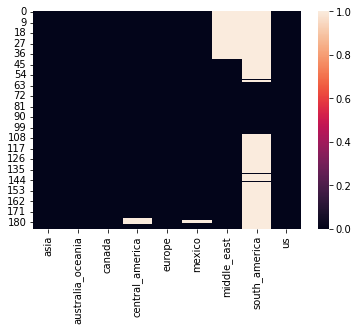

In [17]:
sns.heatmap(df_regions4.iloc[:, 1:].isna())

The regions have missing periods. There are a few options:
- omit some regions from the analysis
- mix the quantities from some regions to obtain full presence
- approach the analysis from a different angle

I have chosen the last one.

## Second approach - group the quantities by summary (international or domestic).

In [18]:
columns_geo = ['activity_period','geo_summary','cargo_metric_tons']
columns_geo

['activity_period', 'geo_summary', 'cargo_metric_tons']

In [19]:
df_geo1 = df[columns_geo]
df_geo1

,activity_period,geo_summary,cargo_metric_tons
0,200507,Domestic,20.603873
1,200507,Domestic,48.475778
2,200507,Domestic,25.141687
3,200507,Domestic,22.806101
4,200507,Domestic,33.649409
...,...,...,...
34032,202012,International,0.869098
34033,202012,International,4.658926
34034,202012,International,83.367144
34035,202012,International,1.995840


In [20]:
df_geo2 = df_geo1.groupby(['activity_period', 'geo_summary'], as_index = False)['cargo_metric_tons'].sum()
df_geo2

,activity_period,geo_summary,cargo_metric_tons
0,200507,Domestic,21073.762030
1,200507,International,26538.209108
2,200508,Domestic,21457.336169
3,200508,International,25393.514126
4,200509,Domestic,25574.068244
...,...,...,...
367,202010,International,19552.939661
368,202011,Domestic,18491.527908
369,202011,International,20370.579516
370,202012,Domestic,22364.137000


In [21]:
grouper_geo = df_geo2.groupby('geo_summary')

df_geo = pd.concat([pd.Series(v['cargo_metric_tons'].tolist(), name = k) for k, v in grouper_geo], axis = 1)

df_geo

,Domestic,International
0,21073.762030,26538.209108
1,21457.336169,25393.514126
2,25574.068244,25688.680719
3,23887.538992,24401.924114
4,23311.030177,26302.333932
...,...,...
181,16906.271658,19942.299015
182,17829.679694,19884.838327
183,19006.163417,19552.939661
184,18491.527908,20370.579516


In [22]:
df_geo['date'] = periods
columns_geo = df_geo.columns.tolist()
columns_geo = columns_geo[-1:] + columns_geo[:-1]
print(columns_geo)
df_geo = df_geo[columns_geo]
df_geo

['date', 'Domestic', 'International']


,date,Domestic,International
0,200507,21073.762030,26538.209108
1,200508,21457.336169,25393.514126
2,200509,25574.068244,25688.680719
3,200510,23887.538992,24401.924114
4,200511,23311.030177,26302.333932
...,...,...,...
181,202008,16906.271658,19942.299015
182,202009,17829.679694,19884.838327
183,202010,19006.163417,19552.939661
184,202011,18491.527908,20370.579516


<AxesSubplot:>

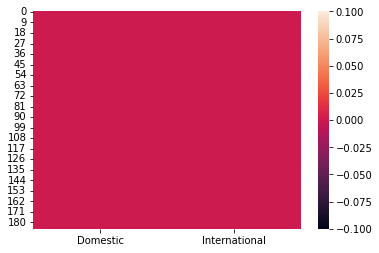

In [23]:
sns.heatmap(df_geo[['Domestic', 'International']].isna())

In [24]:
df_geo['date'] = pd.to_datetime(df_geo['date'], format='%Y%m').dt.strftime('%Y-%m')
df_geo = df_geo.set_index(df_geo['date'])
df_geo = df_geo.drop('date', axis = 1)
df_geo

,Domestic,International
date,,
2005-07,21073.762030,26538.209108
2005-08,21457.336169,25393.514126
2005-09,25574.068244,25688.680719
2005-10,23887.538992,24401.924114
2005-11,23311.030177,26302.333932
...,...,...
2020-08,16906.271658,19942.299015
2020-09,17829.679694,19884.838327
2020-10,19006.163417,19552.939661


In [25]:
df_geo.describe()

,Domestic,International
count,186.000000,186.000000
mean,15858.515288,23762.985054
std,3805.781751,4742.881891
min,9769.123325,12420.702453
25%,12721.673651,20170.524793
50%,15250.277850,23425.914809
75%,18220.336003,27523.702282
max,28026.117806,34152.176318


In [26]:
correlation, _ = stats.pearsonr(df_geo['Domestic'].values, df_geo['International'].values)
correlation

0.5435735936112407

Pearson’s correlation coefficient is above 0.5, so it means high correlation. The model should be done using both series together.

In [27]:
geo_ticks = []
for i in range(len(df_geo.index)):
    if i%3 == 0:
        geo_ticks.append(df_geo.index[i])
geo_ticks

['2005-07',
 '2005-10',
 '2006-01',
 '2006-04',
 '2006-07',
 '2006-10',
 '2007-01',
 '2007-04',
 '2007-07',
 '2007-10',
 '2008-01',
 '2008-04',
 '2008-07',
 '2008-10',
 '2009-01',
 '2009-04',
 '2009-07',
 '2009-10',
 '2010-01',
 '2010-04',
 '2010-07',
 '2010-10',
 '2011-01',
 '2011-04',
 '2011-07',
 '2011-10',
 '2012-01',
 '2012-04',
 '2012-07',
 '2012-10',
 '2013-01',
 '2013-04',
 '2013-07',
 '2013-10',
 '2014-01',
 '2014-04',
 '2014-07',
 '2014-10',
 '2015-01',
 '2015-04',
 '2015-07',
 '2015-10',
 '2016-01',
 '2016-04',
 '2016-07',
 '2016-10',
 '2017-01',
 '2017-04',
 '2017-07',
 '2017-10',
 '2018-01',
 '2018-04',
 '2018-07',
 '2018-10',
 '2019-01',
 '2019-04',
 '2019-07',
 '2019-10',
 '2020-01',
 '2020-04',
 '2020-07',
 '2020-10']

In [28]:
geo_columns = list(df_geo)
colors = {geo_columns[0]: 'green', geo_columns[1]: 'red'}

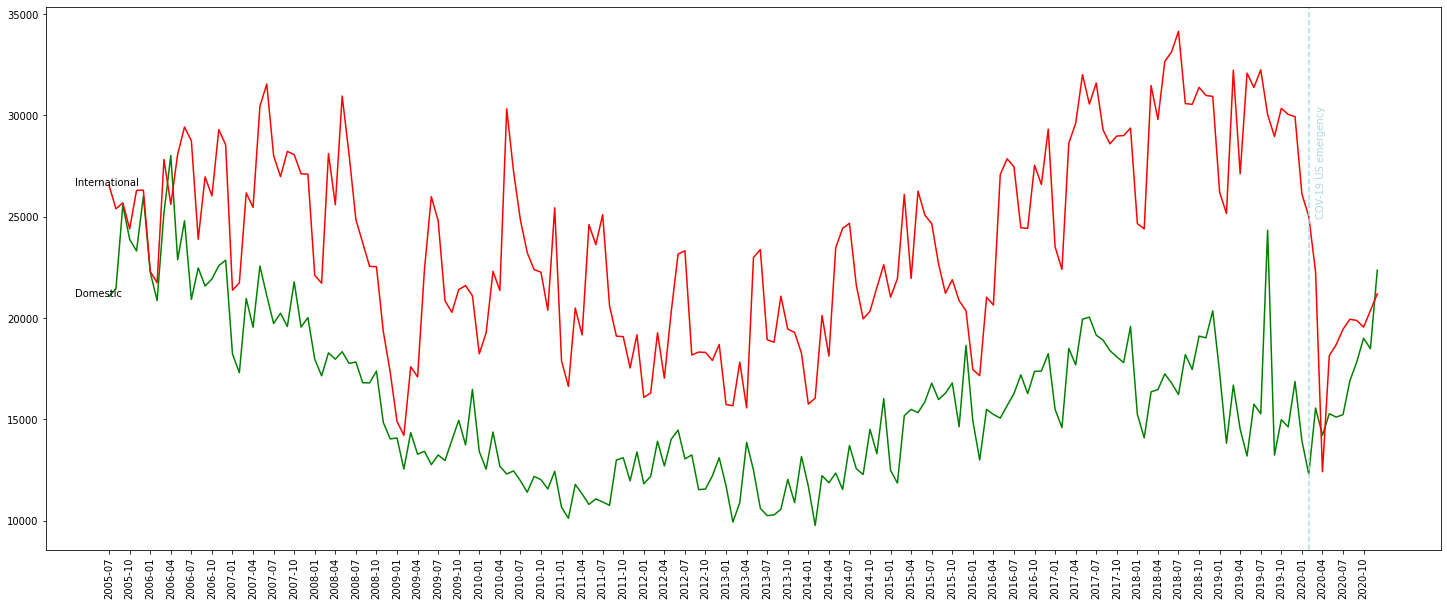

In [29]:
fig = plt.gcf()
fig.set_size_inches(25., 10.)

for column in geo_columns:
    plt.plot(df_geo[column], color = colors[column])
    plt.annotate(column, (-5., df_geo[column][0]))
plt.xticks(range(0, len(df_geo), 3), geo_ticks, rotation = 'vertical')

plt.axvline('2020-02', color = 'lightblue', linestyle = 'dashed')
plt.text('2020-03',25000.,'COV-19 US emergency',rotation=90, color = 'lightblue')

plt.show()

In [30]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_geo)
scaled_data

array([[0.61919495, 0.64963411],
       [0.64020465, 0.59695959],
       [0.86569259, 0.61054203],
       [0.77331544, 0.55133038],
       [0.74173802, 0.63878003],
       [0.89014986, 0.63922402],
       [0.68451386, 0.45483737],
       [0.6077781 , 0.42915609],
       [0.84443451, 0.70889538],
       [1.        , 0.60671705],
       [0.71802676, 0.72082196],
       [0.82333148, 0.78271155],
       [0.61072904, 0.75115246],
       [0.69617425, 0.52783196],
       [0.64699929, 0.66945711],
       [0.66599715, 0.62628577],
       [0.70202272, 0.7765576 ],
       [0.71695443, 0.74224931],
       [0.4632602 , 0.41200743],
       [0.41285749, 0.42881279],
       [0.61372471, 0.63292324],
       [0.53569061, 0.60025424],
       [0.70088628, 0.82992909],
       [0.6212449 , 0.88013186],
       [0.54576735, 0.71749783],
       [0.57362313, 0.67003901],
       [0.53767477, 0.72724843],
       [0.65838869, 0.72002843],
       [0.53618331, 0.67640928],
       [0.56175186, 0.67558209],
       [0.

In [31]:
look_back = 36 # predicting the values basing on last {look_back} months

gen = TimeseriesGenerator(scaled_data, scaled_data,
                               length=look_back, sampling_rate=1,
                               batch_size=len(df_geo)-look_back)
X, Y = gen[0]

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123, shuffle = False)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((105, 36, 2), (45, 36, 2), (105, 2), (45, 2))

In [33]:
model = Sequential()
model.add(LSTM(256, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences = False))
model.add(Dropout(0.1))
model.add(Dense(2))
model.summary()

2021-11-10 03:48:07.011524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 03:48:07.016510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-10 03:48:07.016532: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-10 03:48:07.017118: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 256)           265216    
_________________________________________________________________
dropout (Dropout)            (None, 36, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 36, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

In [34]:
model.compile(optimizer = 'adam', loss = 'mse')

In [35]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 8)

Epoch 1/100


2021-11-10 03:48:07.578472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


14/14 [==============================] - 4s 74ms/step - loss: 0.0432
Epoch 2/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0241
Epoch 3/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0213
Epoch 4/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0180
Epoch 5/100
14/14 [==============================] - 1s 74ms/step - loss: 0.0231
Epoch 6/100
14/14 [==============================] - 1s 76ms/step - loss: 0.0212
Epoch 7/100
14/14 [==============================] - 1s 71ms/step - loss: 0.0194
Epoch 8/100
14/14 [==============================] - 1s 74ms/step - loss: 0.0199
Epoch 9/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0208
Epoch 10/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0184
Epoch 11/100
14/14 [==============================] - 1s 71ms/step - loss: 0.0172
Epoch 12/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0182
Epoch 13/100
14/14 [=================

In [36]:
Y_pred = model.predict(X_test)
Y_pred

array([[0.37306368, 0.5746388 ],
       [0.3751601 , 0.63673276],
       [0.40814692, 0.7409679 ],
       [0.45374364, 0.7797772 ],
       [0.49571234, 0.7497986 ],
       [0.51853865, 0.6719721 ],
       [0.52203643, 0.5902397 ],
       [0.51252663, 0.5258769 ],
       [0.4950421 , 0.47953182],
       [0.48291498, 0.46564257],
       [0.44752437, 0.41465208],
       [0.39571238, 0.34990752],
       [0.36747783, 0.3675986 ],
       [0.3633331 , 0.4412064 ],
       [0.3850273 , 0.55380887],
       [0.41989064, 0.62611264],
       [0.452026  , 0.632675  ],
       [0.46911705, 0.58373374],
       [0.47250688, 0.5255589 ],
       [0.47600502, 0.4943222 ],
       [0.47967649, 0.47871757],
       [0.4885137 , 0.48421717],
       [0.47323596, 0.44412735],
       [0.42880762, 0.3693069 ],
       [0.40143836, 0.36435276],
       [0.37009954, 0.36132044],
       [0.34666735, 0.39771917],
       [0.33733112, 0.45571285],
       [0.34007007, 0.50428474],
       [0.3791731 , 0.56091124],
       [0.

In [37]:
Y_pred_view = scaler.inverse_transform(Y_pred)
Y_pred_view

array([[16580.145, 24908.451],
       [16618.42 , 26257.844],
       [17220.66 , 28523.03 ],
       [18053.12 , 29366.412],
       [18819.34 , 28714.932],
       [19236.08 , 27023.646],
       [19299.94 , 25247.482],
       [19126.32 , 23848.781],
       [18807.104, 22841.637],
       [18585.7  , 22539.8  ],
       [17939.574, 21431.703],
       [16993.643, 20024.707],
       [16478.164, 20409.16 ],
       [16402.494, 22008.768],
       [16798.564, 24455.785],
       [17435.064, 26027.053],
       [18021.76 , 26169.664],
       [18333.791, 25106.098],
       [18395.68 , 23841.873],
       [18459.543, 23163.05 ],
       [18526.574, 22823.94 ],
       [18687.916, 22943.455],
       [18408.99 , 22072.242],
       [17597.861, 20446.285],
       [17098.182, 20338.625],
       [16526.03 , 20272.727],
       [16098.228, 21063.727],
       [15927.776, 22324.016],
       [15977.781, 23379.553],
       [16691.686, 24610.13 ],
       [16957.639, 23528.367],
       [16981.469, 22386.6  ],
       [

In [38]:
indexes_pred = np.arange(len(df_geo) - Y_pred.shape[0], len(df_geo))
df_geo_pred_index = [df_geo.index[x] for x in indexes_pred]
df_geo_pred = pd.DataFrame(Y_pred_view, columns = geo_columns, index = df_geo_pred_index)
df_geo_pred

,Domestic,International
2017-04,16580.144531,24908.451172
2017-05,16618.419922,26257.843750
2017-06,17220.660156,28523.029297
2017-07,18053.119141,29366.412109
2017-08,18819.339844,28714.931641
2017-09,19236.080078,27023.646484
2017-10,19299.939453,25247.482422
2017-11,19126.320312,23848.781250
2017-12,18807.103516,22841.636719
2018-01,18585.699219,22539.800781


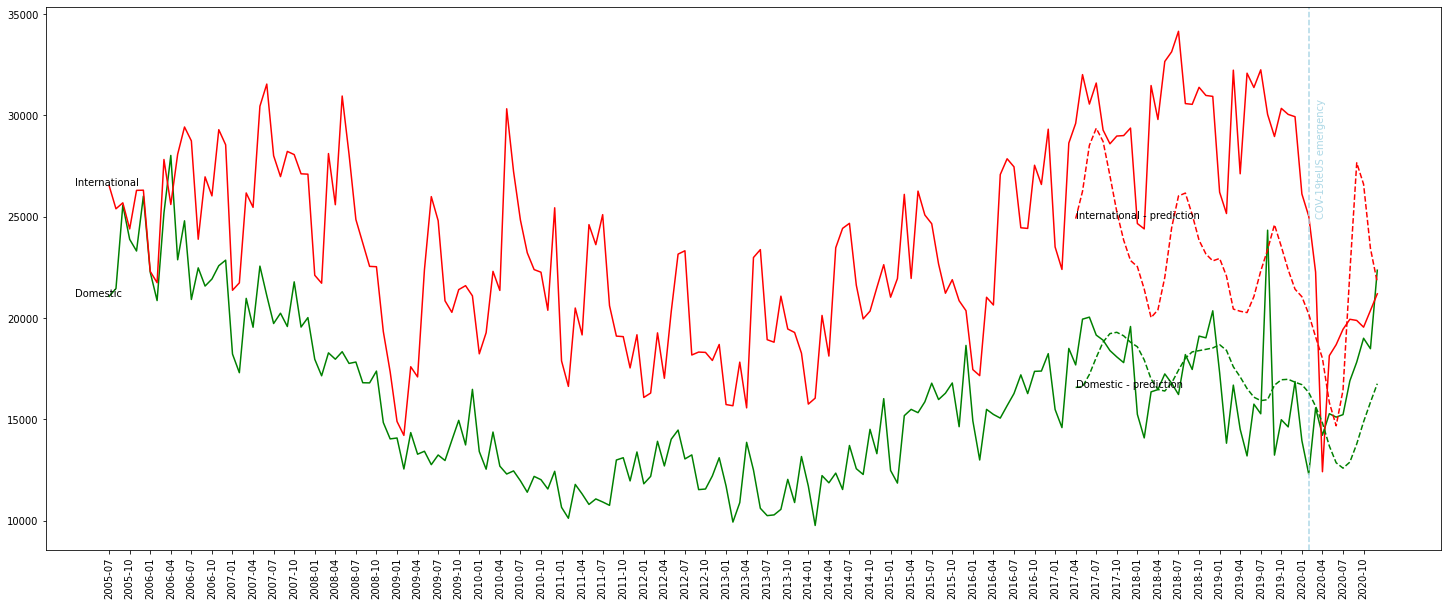

In [39]:
fig = plt.gcf()
fig.set_size_inches(25., 10.)

for column in geo_columns:
    plt.plot(df_geo[column], color = colors[column])
    plt.annotate(column, (-5., df_geo[column][0]))
plt.xticks(range(0, len(df_geo), 3), geo_ticks, rotation = 'vertical')

plt.axvline('2020-02', color = 'lightblue', linestyle = 'dashed')
plt.text('2020-03',25000.,'COV-19teUS emergency',rotation=90, color = 'lightblue')

### ADD PREDICTIONS TO THE PLOT
for column in geo_columns:
    plt.plot(df_geo_pred[column], color = colors[column], linestyle = 'dashed')
    plt.annotate(f'{column} - prediction', (df_geo_pred.index[0], df_geo_pred[column][0]))

plt.show()